In [ ]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.utils import effective_n_jobs
import nltk
import wordcloud
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

# Step 1: Loading data 

In [2]:
data_actual = pd.read_csv('./prediction_cs122.csv')

In [ ]:
data_actual_collapsed = data_actual[data_actual['Predicted'] == 1].groupby('candidate_user_name').agg(''.join)

In [4]:
data_actual_collapsed.reset_index(inplace = True)
data_actual_collapsed = data_actual_collapsed[['candidate_user_name', 'tweet']]

# Step 2: Tokenizing and storing tweets 
We tokenize each of the tweets and remove stop words that affect the coherency of the topics

In [ ]:
tweet_regex = "[^a-z\s]"
tweet_stop = ['like', 'co', 'https', 'amp', 'would', 'know', 'get', 'us', 'one', 
              'go', 'ncpol', 'ginny', 'iam', 'ncga', 'ncpol','roaring', 'fape', 
              'ftzoqz','gsmathrive', 'pge','wtfthere', 'camden', 'thv', 'yxgjw', 
              'followup', 'bydoes', 'atgy', 'fewest', 'xbthe', 'dcvpobp', 'emw',
             'jpc', 'ovqe', 'kjsvzrtyou', 'heaxfynndon', 'jjyx', 'kjqjpcatjtcongratulations', 
              'qyr', 'quhtge', 'iaw', 'hdg', 'ankeny', 'lwiacckis', 'nrcc', 'nturtnh', 'ycbvysgchn', 
             'pixdsgw', 'xgxensj', 'vjust', 'ijthanks', 'horsesinourhandsughhh', 'mnqi', 
              'panies', 'rd', 'lnk', 'wsmsldrmsfi', 'dvejdlnh', 'bwell', 'fzn', 'etjust', 
              'gutlessdo', 'curran', 'xuf', 'yearsthese', 'horsesinourhandsughhh', 'oyndqu', 'nlast', 'ngv', 
              'lbeiwsktufgo', 'jmmrfprsnlsuper', 'djcaicp', 'res', 'h', 'dhey', 'hiutlbncbkhey',
              'eynmqnwyp', 'vonmg', 'okfwqsixdb', 'zgft', 'os', 'qcuedasd', 'itcay', 'pdzjgsusan', 'need',
             'make', 'back', 'think', 'bwnvkfr', 'rqq', 'wnmdgqkwy', 'zrrvpyfvz', 'bmvkfkktwzyour', 'zdsyvhbvvktourists',
             'tredyffrin', 'raniere', 'yhqxbsfmyt', 'xbc', 'mitchand', 'pqkiwu', 'zhu', 'concurrences', 'qapbmcsbs', 'fti', 
             'pzjfvpvmhu', 'vhpvyyy', 'hey', 'ob', 'mds', 'baugh', 'priscilla', 'germaine', 'ross', 
             'ny', 'congressional', 'election', 'maine', 'senate', 'state', 'voting', 'right', 
             'good', 'country', 'votesafe', 'grassroots', 'latogether', 'equalpay', 'organizers', 'gofundme', 'sela', 
              'southeastla', 'erick', 'lakeshow', 'latinasareessentialit', 'latinasareessentialstill', 
              'kjyh', 'lavotesvoters', 'mqgulbobby', 'people', 'want', 'left', 'cobb', 'time', 'state', 
             'america', 'american', 'president', 'state', 'biden', 'stefanik',
             'shiptrump', 'missourideservesbetter', 'plank', 'people', 'trump', 'vote', 'court', 'want', 'time', 
              'take', 'election', 'let', 'going', 'u', 'president', 'country', 'nothing', 
             'retire', 'graham', 'please', 'az', 'pa', 'armenian', 'mi', 'senator', 'va', 'nv', 'fl', 'swing', 'republican', 
              'senator', 'really', 'say', 'see', 'saw', 'party', 'never', 'keep']

def tokenize_tweets(text_series):
    '''
    Cleans + tokenizes Pandas series of strings from the Salem Witch dataset.
    
    Returns pandas series of lists of tokens
    '''
    clean = text_series.str.lower() \
                       .str.replace(tweet_regex,
                                    " ",
                                    regex=True)

    stop = nltk.corpus.stopwords.words('english') + tweet_stop

    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    tokens = clean.apply(tokenize)
    return tokens

In [52]:
data_actual_collapsed['tokens'] = tokenize_tweets(data_actual_collapsed['tweet'])

In [8]:
def prepare_data(tokens):
    '''
    Prepares Pandas series of lists of tokens for use within a Gensim topic model
    
    Returns an id2word dictionary + bag of words corpus
    '''
   
    dictionary = corpora.Dictionary([i for i in tokens])
    
    bow_corpus = [dictionary.doc2bow(text) for text in tokens]
    
    return dictionary, bow_corpus

In [53]:
dictionary, bow_corpus = prepare_data(data_actual_collapsed['tokens'])

# Step 3: Computing coherence values 
We compute coherence scores for different numbers of topics to identify which number would produce the most interpretable topics

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    '''
    Computes Coherence values for LDA models with differing numbers of topics.
    
    Returns list of models along with their respective coherence values (pick
    models with the highest coherence)
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics= num_topics,
                                                 workers=effective_n_jobs(-1),
                                                 passes=60,
                                                 iterations=100)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model, 
                                                               corpus=corpus,
                                                               dictionary=dictionary,
                                                               coherence='u_mass')
        
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [54]:
model_list1, coherence_values1 = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        texts = data_actual_collapsed['tokens'],
                                                        limit=20, start=2, step=2)

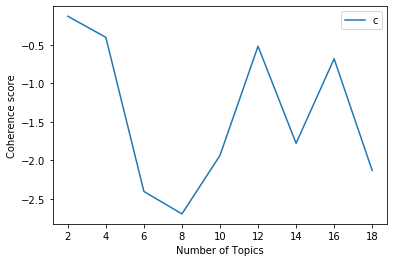

In [55]:
import matplotlib.pyplot as plt
plt.plot(range(2, 20, 2), coherence_values1)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

Topic 7: 
['democrats', 'even', 'way', 'republicans', 'aoc', 'much', 'stop', 'better', 'said', 'love', 'money', 'believe', 'sure', 'help', 'change']
Topic 2: 
['republicans', 'democrats', 'aoc', 'stop', 'even', 'done', 'much', 'said', 'way', 'money', 'better', 'years', 'great', 'americans', 'dems']
Topic 1: 
['even', 'stop', 'care', 'aoc', 'got', 'years', 'every', 'much', 'look', 'americans', 'democrats', 'republicans', 'stimulus', 'women', 'dems']
Topic 11: 
['brother', 'support', 'thank', 'covid', 'omar', 'ballot', 'today', 'new', 'must', 'day', 'fraud', 'ilhan', 'police', 'campaign', 'help']
Topic 0: 
['recognizeartsakh', 'azerbaijan', 'artsakh', 'turkey', 'lindsey', 'decided', 'nh', 'presidential', 'hug', 'voters', 'may', 'cosponsoring', 'sanctionazerbaijan', 'turkish', 'oh']
Topic 4: 
['stimulus', 'nancy', 'americans', 'help', 'covid', 'care', 'bill', 'pelosi', 'done', 'democrats', 'stop', 'money', 'years', 'house', 'even']
Topic 10: 
['jaime', 'flipthe', 'hall', 'town', 'carolyn'

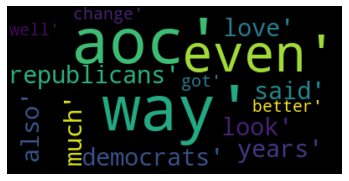

In [58]:
ldamodel = model_list1[5]

for i, topic in ldamodel.show_topics(formatted=False, num_words=15):
    print('Topic {}: \n{}'.format(i, [w[0] for w in topic]))
    
    text = str([w[0] for w in topic])
   
    wc = wordcloud.WordCloud(max_words=20)
    wc.generate(text)
    wc.to_file('Topic'+str(i)+'.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [60]:
ldamodel.save('ldamodel12')